Project root on sys.path: /Users/andregrau/Desktop/Thesis/Python_Tool/simLIS
PV CSV: /Users/andregrau/Desktop/Thesis/Python_Tool/simLIS/data/strategies/generation/latest.csv
Market CSV: /Users/andregrau/Desktop/Thesis/Python_Tool/simLIS/data/strategies/market/latest.csv
Charging Strategy: Generation
Strategy Status: Active

Verwendetes Szenario: industrial_site_3_shift
Ladepunkte: 20
Zeitraum: 2025-01-01 00:00:00+01:00 bis 2025-01-07 23:45:00+01:00
Horizont: 7 Tage

Sessions
Ankünfte mit Ladebedarf: 61
mit Ladezugang: 61
ohne Ladezugang (drive_off): 0
Ziel-SoC nicht erreicht: 3


,session_id,charger_id,arrival_time,parking_duration_min,soc_arrival,soc_end,remaining_energy_kwh
0,2025-01-07_006_00006,0,2025-01-07 23:45:00+01:00,15.0,0.520850,0.520850,33.044542
1,2025-01-02_001_00014,3,2025-01-02 23:45:00+01:00,15.0,0.248880,0.519422,32.293351
2,2025-01-03_002_00005,4,2025-01-03 23:45:00+01:00,15.0,0.408004,0.760115,13.291963


Daytypes: {'working_day': 3, 'saturday': 1, 'sunday_holiday': 3}


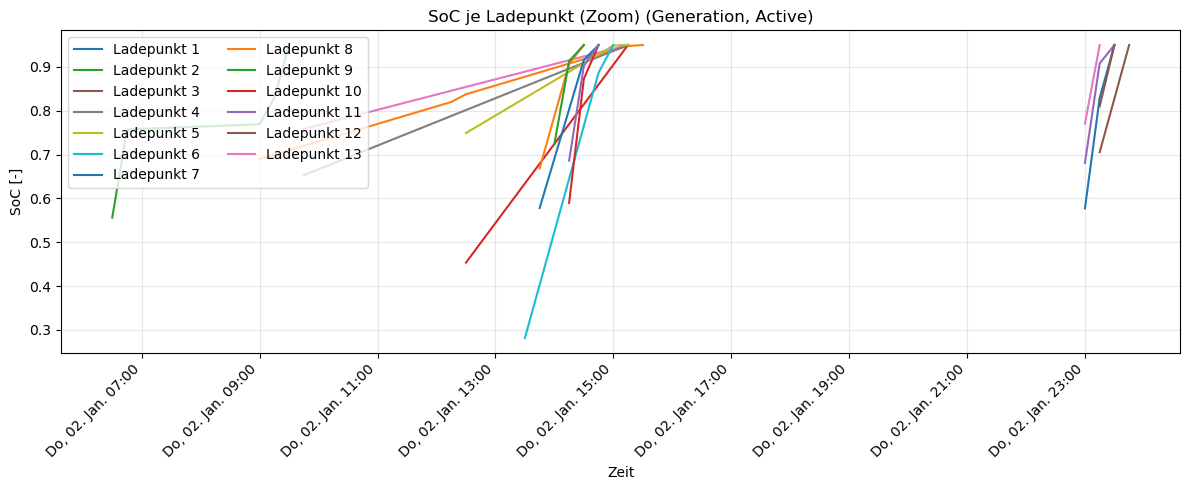

Überschreitungen: 1


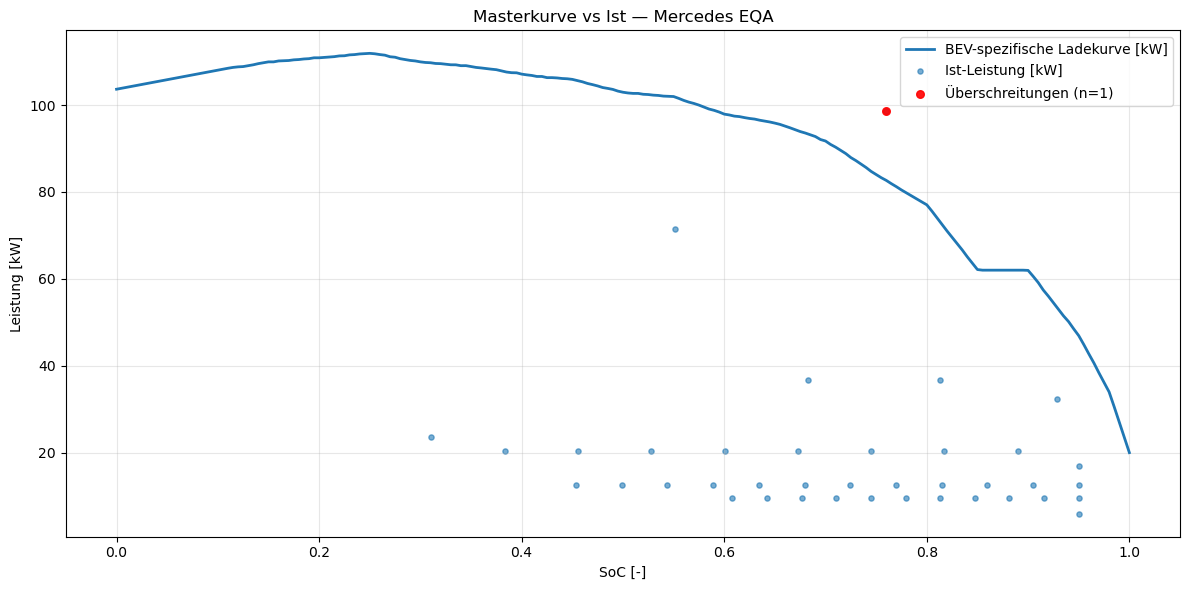

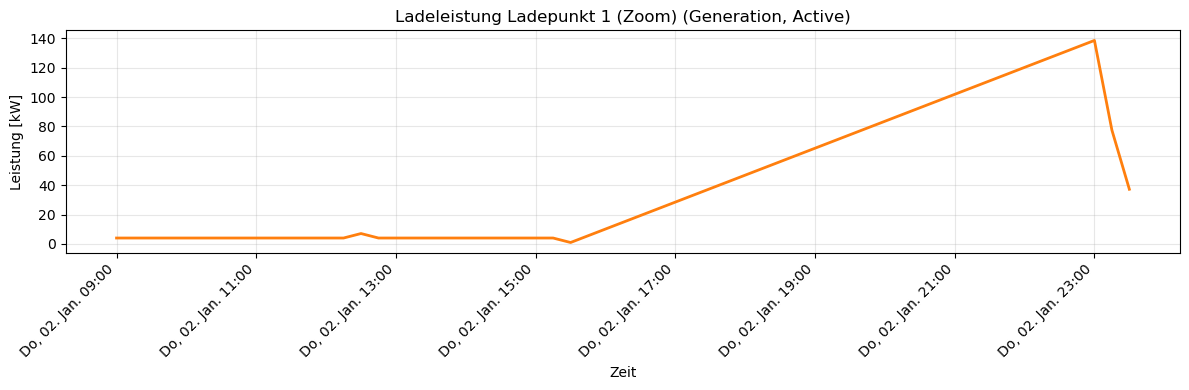

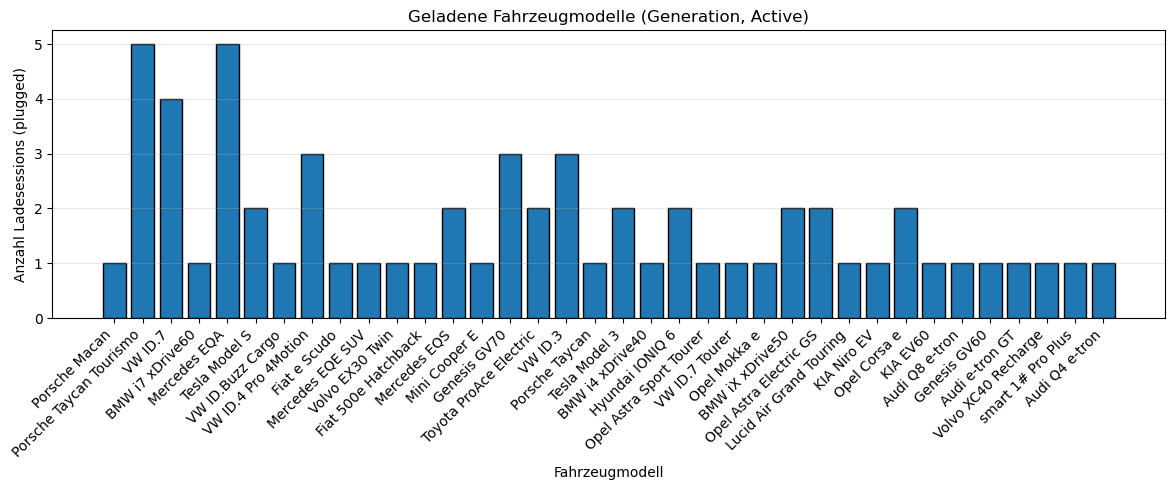

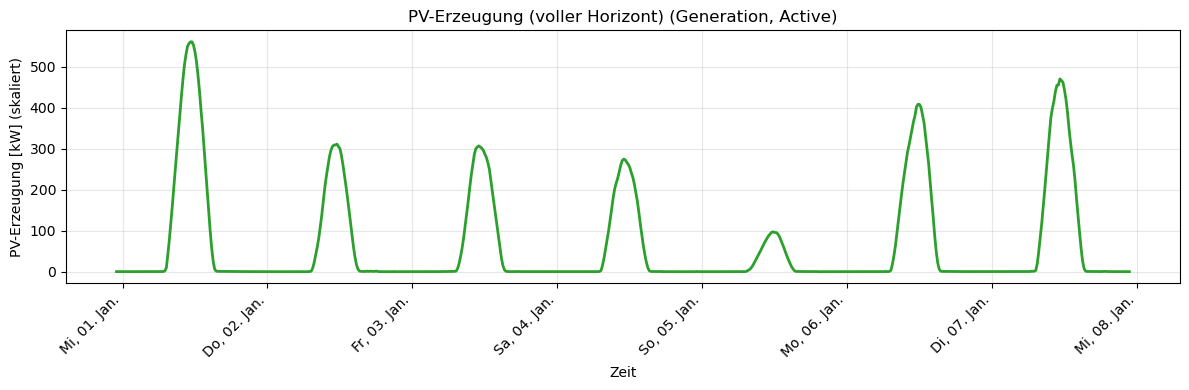

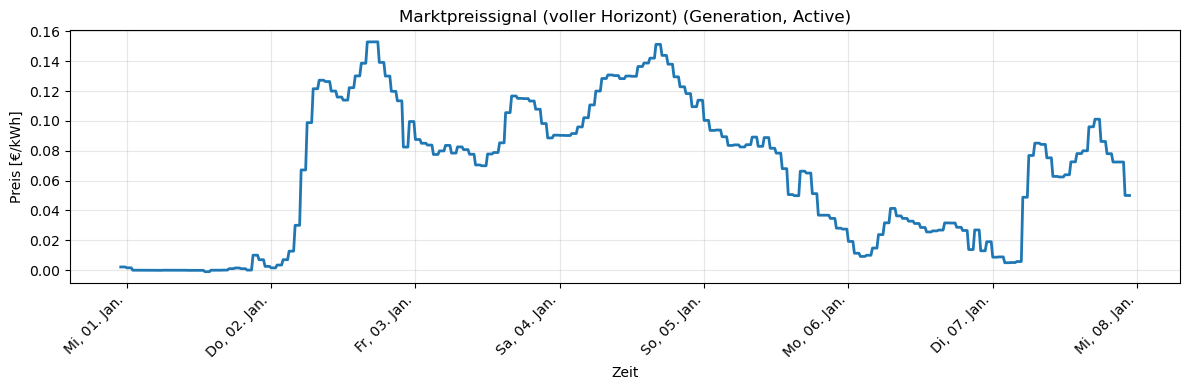

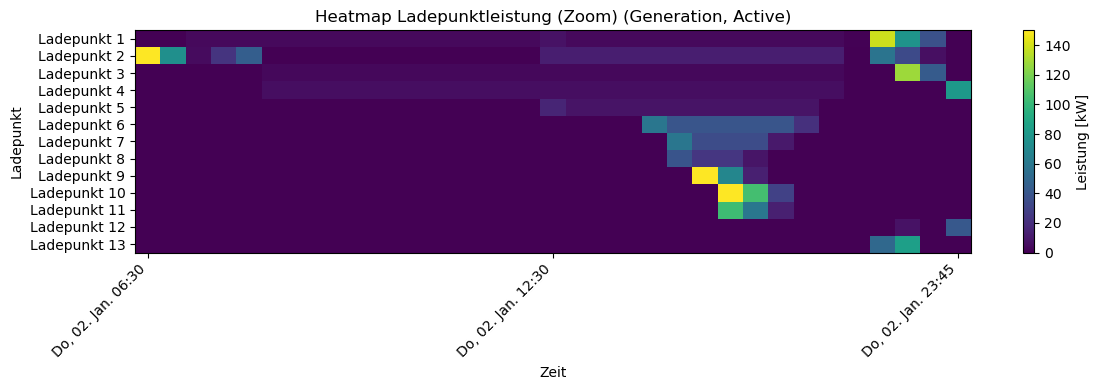

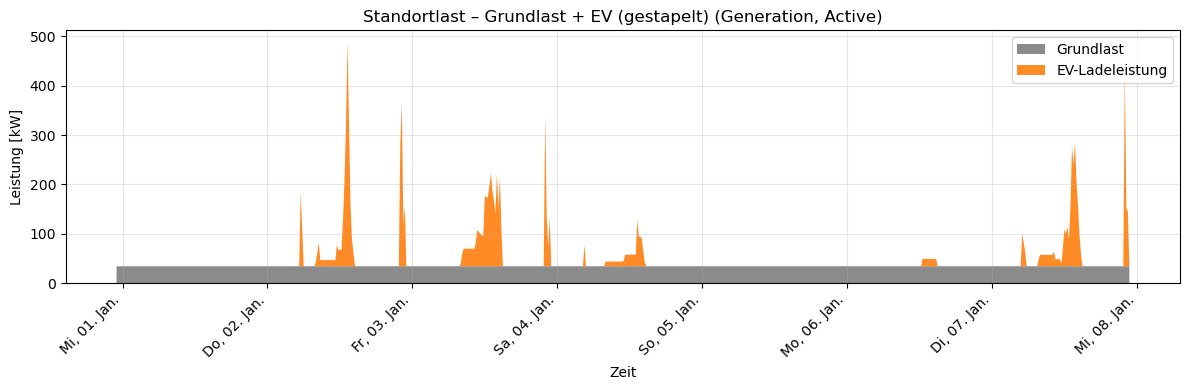

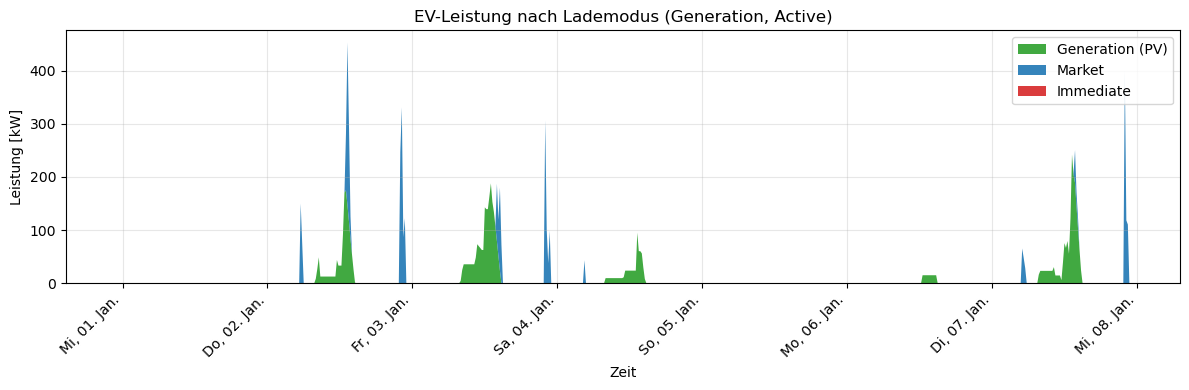

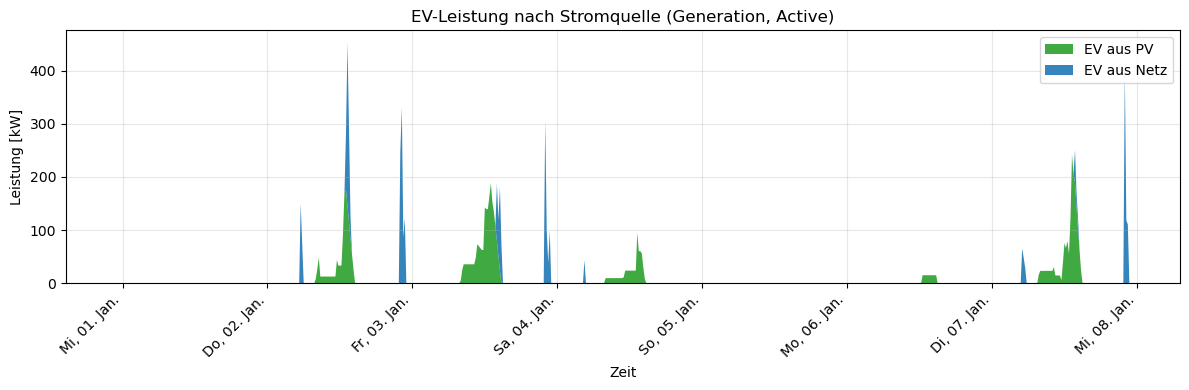

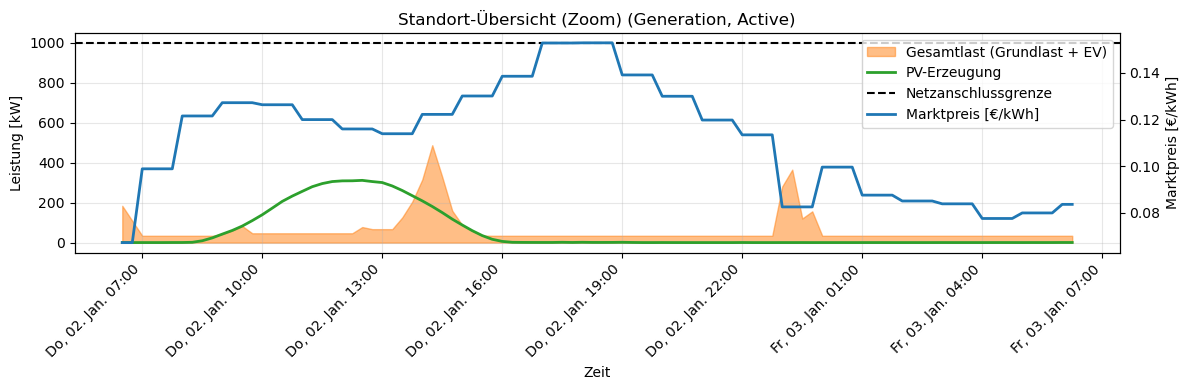

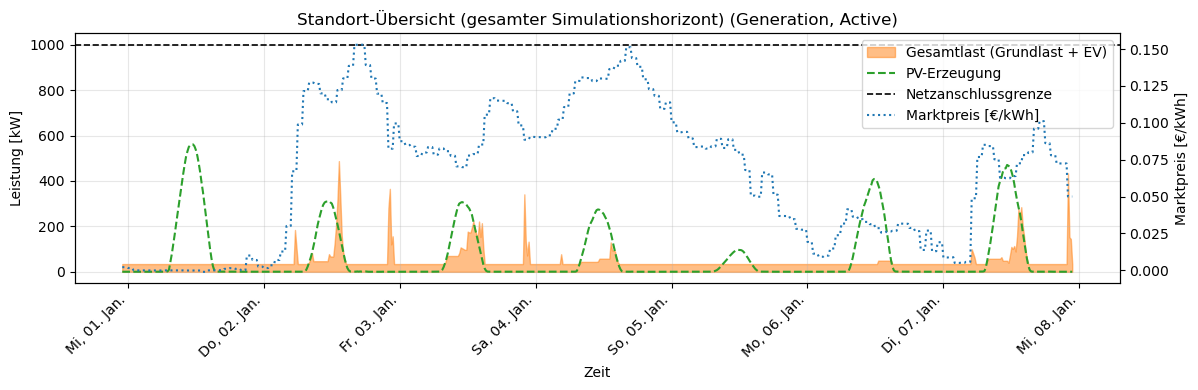

,session_id,charger_id,vehicle_name,arrival_time,departure_time,state_of_charge_at_arrival,state_of_charge_end,charged_site_kwh,charged_pv_site_kwh,charged_market_site_kwh,charged_immediate_site_kwh,remaining_site_kwh
0,2025-01-02_001_00017,0,Porsche Macan,2025-01-02 06:00:00+01:00,2025-01-02 15:45:00+01:00,0.679923,0.95,27.007687,27.007687,0.000000,0.0,0.0
1,2025-01-02_001_00000,1,Porsche Taycan Tourismo,2025-01-02 06:30:00+01:00,2025-01-02 09:45:00+01:00,0.153080,0.95,74.113572,17.905109,56.208463,0.0,0.0
2,2025-01-02_001_00008,2,VW ID.7,2025-01-02 07:00:00+01:00,2025-01-02 16:00:00+01:00,0.750000,0.95,17.200000,17.200000,0.000000,0.0,0.0
3,2025-01-02_001_00006,3,BMW i7 xDrive60,2025-01-02 07:45:00+01:00,2025-01-02 16:00:00+01:00,0.639634,0.95,31.657290,31.657290,0.000000,0.0,0.0
4,2025-01-02_001_00002,1,Mercedes EQA,2025-01-02 12:30:00+01:00,2025-01-02 20:30:00+01:00,0.408554,0.95,37.901229,37.901229,0.000000,0.0,0.0
5,2025-01-02_001_00012,4,Tesla Model S,2025-01-02 12:30:00+01:00,2025-01-02 21:15:00+01:00,0.710360,0.95,23.963956,23.963956,0.000000,0.0,0.0
6,2025-01-02_001_00011,5,VW ID.Buzz Cargo,2025-01-02 13:30:00+01:00,2025-01-02 22:15:00+01:00,0.103045,0.95,69.450270,69.450270,0.000000,0.0,0.0
7,2025-01-02_001_00007,6,VW ID.4 Pro 4Motion,2025-01-02 13:45:00+01:00,2025-01-02 22:15:00+01:00,0.387181,0.95,43.337037,43.337037,0.000000,0.0,0.0
8,2025-01-02_001_00009,7,Fiat e Scudo,2025-01-02 13:45:00+01:00,2025-01-02 21:30:00+01:00,0.472839,0.95,23.858026,23.858026,0.000000,0.0,0.0
9,2025-01-02_001_00013,8,Mercedes EQE SUV,2025-01-02 14:00:00+01:00,2025-01-02 19:15:00+01:00,0.312031,0.95,58.055134,14.703065,43.352069,0.0,0.0


In [1]:
# =============================================================================
# A) Scenario Setup + Notebook-Parameter
# =============================================================================
scenario_name = "industrial_site_3_shift"
scenario_path = f"../scenarios/{scenario_name}.yaml"

zoom_days = 1
random_seed = 43

preview_rows_n = 10             # Anzahl Zeilen in der Plugged-Sessions-Vorschau

FIGSIZE_WIDE = (12, 4)
FIGSIZE_MEDIUM = (12, 5)
FIGSIZE_TALL = (12, 6)

# =============================================================================
# B) Imports (PEP8)
# =============================================================================
import sys
import warnings
from collections import Counter
from datetime import datetime, timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from zoneinfo import ZoneInfo


warnings.simplefilter("default", UserWarning)

# =============================================================================
# C) Plot Colors (semantisch konsistent)
# =============================================================================
COLOR_PV = "#2ca02c"          # grün
COLOR_MARKET = "#1f77b4"      # blau
COLOR_GRID = COLOR_MARKET
COLOR_IMMEDIATE = "#d62728"   # rot
COLOR_SITE_LOAD = "#ff7f0e"   # orange
COLOR_BASELOAD = "#7f7f7f"    # grau
COLOR_TOTAL = "black"
COLOR_GRID_LIMIT = "black"

# =============================================================================
# D) Notebook Helper Functions
# =============================================================================
def ensure_project_root_on_syspath() -> str:
    """
    Sucht den Projekt-Root (Ordner, der 'model/' enthält) und fügt ihn in sys.path ein.
    """
    current_working_directory = Path.cwd().resolve()
    candidate_directories = [current_working_directory] + list(current_working_directory.parents)

    for candidate in candidate_directories:
        model_directory = candidate / "model"
        if model_directory.exists() and model_directory.is_dir():
            root_path = str(candidate)
            if root_path not in sys.path:
                sys.path.insert(0, root_path)
            return root_path

    fallback_root = str((current_working_directory / "..").resolve())
    if fallback_root not in sys.path:
        sys.path.insert(0, fallback_root)
    return fallback_root

def first_existing_column(dataframe: pd.DataFrame, candidates: list[str]) -> str | None:
    """
    Gibt den ersten Spaltennamen aus `candidates` zurück, der in `dataframe.columns` existiert.
    Wenn keine Kandidaten existieren, wird None zurückgegeben.
    """
    for name in candidates:
        if name in dataframe.columns:
            return name
    return None

GERMAN_WEEKDAYS = ["Mo", "Di", "Mi", "Do", "Fr", "Sa", "So"]
GERMAN_MONTHS = ["Jan.", "Feb.", "Mär.", "Apr.", "Mai", "Jun.", "Jul.", "Aug.", "Sep.", "Okt.", "Nov.", "Dez."]

def apply_german_time_axis(
    ax,
    tz: str = "Europe/Berlin",
    show_time: bool = False,
    rotation: int = 45,
    ha: str = "right",
    minticks: int = 4,
    maxticks: int = 10,
):
    """
    Formatiert die x-Achse in Deutsch:
      - ohne Uhrzeit:  'Mo, 31. Jan.'
      - mit Uhrzeit:   'Mo, 31. Jan. 23:00'
    """
    tzinfo = ZoneInfo(tz)

    def _fmt(x, pos=None):
        dt = mdates.num2date(x).astimezone(tzinfo)
        wd = GERMAN_WEEKDAYS[dt.weekday()]
        mon = GERMAN_MONTHS[dt.month - 1]
        if show_time:
            return f"{wd}, {dt.day:02d}. {mon} {dt:%H:%M}"
        return f"{wd}, {dt.day:02d}. {mon}"

    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks))
    ax.xaxis.set_major_formatter(FuncFormatter(_fmt))

    for lbl in ax.get_xticklabels():
        lbl.set_rotation(rotation)
        lbl.set_ha(ha)


# =============================================================================
# E) Load simulation module (Variante A)
# =============================================================================
project_root = ensure_project_root_on_syspath()
print("Project root on sys.path:", project_root)

import model.simulation as sim

# =============================================================================
# F) Shortcuts (Builder + Kernfunktionen)
# =============================================================================
load_scenario = sim.read_scenario_from_yaml
build_strategy_signal_series = getattr(sim, "build_strategy_signal_series", None)

build_plugged_sessions_preview_table = sim.build_plugged_sessions_preview_table
summarize_sessions = sim.summarize_sessions

build_power_per_charger_timeseries = sim.build_power_per_charger_timeseries
build_soc_timeseries_by_charger = sim.build_soc_timeseries_by_charger
build_charger_power_heatmap_matrix = sim.build_charger_power_heatmap_matrix
build_ev_power_by_source_timeseries = sim.build_ev_power_by_source_timeseries
build_site_overview_plot_data = sim.build_site_overview_plot_data
build_ev_power_by_mode_timeseries_dataframe = sim.build_ev_power_by_mode_timeseries_dataframe
validate_against_master_curves = sim.validate_against_master_curves

# =============================================================================
# G) Load scenario + resolve relative paths
# =============================================================================
scenario = load_scenario(scenario_path)
scenario = sim.resolve_paths_relative_to_yaml(scenario, scenario_path)

print("PV CSV:", scenario["site"].get("generation_strategy_csv"))
print("Market CSV:", scenario["site"].get("market_strategy_csv"))

site_configuration = scenario["site"]

# =============================================================================
# H) Build timestamps + input time series
# =============================================================================
timestamps = sim.build_simulation_timestamps(scenario)

holiday_dates = sim.get_holiday_dates_from_scenario(scenario, timestamps)

time_resolution_min = int(scenario["time_resolution_min"])
step_hours = float(time_resolution_min) / 60.0

base_load_kwh_per_step = sim.build_base_load_kwh_per_step(scenario, timestamps)

# Strategy signals
(
    pv_generation_kwh_per_step,
    pv_generation_series,
    pv_generation_ylabel,
    market_price_eur_per_kwh,
    market_price_series,
    market_price_ylabel,
) = sim.build_strategy_inputs(
    scenario=scenario,
    timestamps=timestamps,
    normalize_to_internal=True,
)

vehicle_charging_curves_by_name = sim.read_vehicle_load_profiles_from_csv(
    str(scenario["vehicles"]["vehicle_curve_csv"])
)

# =============================================================================
# I) Sample sessions + run simulation
# =============================================================================
random_generator = np.random.default_rng(int(random_seed))

start_datetime = sim.normalize_to_timestamps_timezone(scenario["start_datetime"], timestamps)

simulation_horizon_days = int(scenario["simulation_horizon_days"])

sampled_sessions_all_days = []
for day_index in range(simulation_horizon_days):
    simulation_day_start = (start_datetime + pd.Timedelta(days=day_index)).to_pydatetime()
    sampled_sessions_for_day = sim.sample_sessions_for_simulation_day(
        scenario=scenario,
        simulation_day_start=simulation_day_start,
        timestamps=timestamps,
        holiday_dates=holiday_dates,
        vehicle_curves_by_name=vehicle_charging_curves_by_name,
        random_generator=random_generator,
        day_index=day_index,
    )
    sampled_sessions_all_days.extend(sampled_sessions_for_day)

ev_load_kw, sessions_out, debug_rows, charger_traces = sim.simulate_charging_sessions_fcfs(
    sessions=sampled_sessions_all_days,
    vehicle_curves_by_name=vehicle_charging_curves_by_name,
    scenario=scenario,
    timestamps=timestamps,
    pv_generation_kwh_per_step=pv_generation_kwh_per_step,
    base_load_kwh_per_step=base_load_kwh_per_step,
    market_price_eur_per_kwh=market_price_eur_per_kwh,
    record_debug=True,
    record_charger_traces=True,
)

charging_strategy = str(site_configuration.get("charging_strategy", "immediate")).strip().lower()
strategy_status = "IMMEDIATE" if charging_strategy == "immediate" else "ACTIVE"
sim.show_strategy_status(charging_strategy, strategy_status)

charger_traces_dataframe = pd.DataFrame(charger_traces if charger_traces is not None else [])

# Zoom-Fenster an den ersten Trace-Zeitpunkt hängen (falls vorhanden)
ts = pd.to_datetime(charger_traces_dataframe["timestamp"], errors="coerce") if not charger_traces_dataframe.empty else pd.Series([], dtype="datetime64[ns]")
ts = ts.dropna()

if len(ts) > 0:
    t0 = ts.min()
    window_start = t0.floor(f"{time_resolution_min}min")
    window_end = window_start + pd.Timedelta(days=zoom_days) - pd.Timedelta(minutes=time_resolution_min)
else:
    # Fallback: altes Verhalten (Start der Simulation)
    _, window_start, window_end = sim.initialize_time_window(
        timestamps=timestamps,
        scenario=scenario,
        days=zoom_days,
    )


timeseries_dataframe = sim.build_timeseries_dataframe(
    timestamps=timestamps,
    ev_load_kw=ev_load_kw,
    scenario=scenario,
    debug_rows=debug_rows,
    generation_series=pv_generation_series,
    market_series=market_price_series,
)

# =============================================================================
# J) KPIs
# =============================================================================
print("\nVerwendetes Szenario:", scenario_name)
print("Ladepunkte:", int(site_configuration["number_chargers"]))
print("Zeitraum:", timestamps[0], "bis", timestamps[-1])
print("Horizont:", simulation_horizon_days, "Tage")

summary = summarize_sessions(sessions_out)
print("\nSessions")
print("Ankünfte mit Ladebedarf:", summary["num_sessions_total"])
print("mit Ladezugang:", summary["num_sessions_plugged"])
print("ohne Ladezugang (drive_off):", summary["num_sessions_rejected"])

not_reached_dataframe = pd.DataFrame(summary["not_reached_rows"])

if len(not_reached_dataframe) == 0:
    print("Alle Fahrzeuge haben Ziel-SoC erreicht.")
else:
    # Falls du im Summary schon "remaining_energy_kwh" hast: passt.
    # Falls es mal "remaining_energy" heißen sollte -> zurückbenennen:
    if "remaining_energy" in not_reached_dataframe.columns and "remaining_energy_kwh" not in not_reached_dataframe.columns:
        not_reached_dataframe = not_reached_dataframe.rename(columns={"remaining_energy": "remaining_energy_kwh"})

    # Sortierung
    sort_col = "remaining_energy_kwh" if "remaining_energy_kwh" in not_reached_dataframe.columns else None
    if sort_col is not None:
        not_reached_dataframe = not_reached_dataframe.sort_values(sort_col, ascending=False).reset_index(drop=True)
    else:
        not_reached_dataframe = not_reached_dataframe.reset_index(drop=True)

    # Gewünschte Reihenfolge (nur nehmen, was existiert)
    wanted_cols = [
        "session_id",
        "charger_id",
        "arrival_time",
        "parking_duration_min",
        "soc_arrival",
        "soc_end",
        "remaining_energy_kwh",
    ]
    existing_wanted_cols = [c for c in wanted_cols if c in not_reached_dataframe.columns]
    other_cols = [c for c in not_reached_dataframe.columns if c not in existing_wanted_cols]
    not_reached_dataframe = not_reached_dataframe[existing_wanted_cols + other_cols]

    # vehicle_name sicher entfernen, falls er doch drin ist
    if "vehicle_name" in not_reached_dataframe.columns:
        not_reached_dataframe = not_reached_dataframe.drop(columns=["vehicle_name"])

    print("Ziel-SoC nicht erreicht:", len(not_reached_dataframe))
    display(not_reached_dataframe)

daytypes_calendar = sim.get_daytype_calendar(
    start_datetime=start_datetime,
    horizon_days=simulation_horizon_days,
    holiday_dates=holiday_dates,
)


daytypes_calendar = sim.get_daytype_calendar(
    start_datetime=start_datetime,
    horizon_days=simulation_horizon_days,
    holiday_dates=holiday_dates,
)

sessions_by_day = sim.group_sessions_by_day(sessions_out, only_plugged=False)
sessions_by_day_plugged = sim.group_sessions_by_day(sessions_out, only_plugged=True)
print("Daytypes:", {k: len(v) for k, v in daytypes_calendar.items()})

# =============================================================================
# K) PLOTS
# =============================================================================

def first_existing_column(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

TZ = str(scenario.get("timezone", "Europe/Berlin"))

# 1) SoC je Ladepunkt (Zoom)
soc_by_charger_id = build_soc_timeseries_by_charger(
    charger_traces_dataframe=charger_traces_dataframe,
    charger_ids=list(range(int(site_configuration["number_chargers"]))),
    start=window_start,
    end=window_end,
)

plt.figure(figsize=FIGSIZE_MEDIUM)

for charger_id, soc_dataframe in soc_by_charger_id.items():
    if soc_dataframe is None or len(soc_dataframe) == 0:
        continue

    if "session_id" not in soc_dataframe.columns:
        plt.plot(
            soc_dataframe["timestamp"],
            soc_dataframe["soc"],
            linewidth=1.5,
            label=f"Ladepunkt {charger_id + 1}",
        )
        continue

    soc_dataframe = soc_dataframe.sort_values("timestamp")
    first_segment = True

    for _, segment in soc_dataframe.groupby("session_id"):
        if len(segment) < 2:
            continue

        plt.plot(
            segment["timestamp"],
            segment["soc"],
            linewidth=1.5,
            label=f"Ladepunkt {charger_id + 1}" if first_segment else None,
        )
        first_segment = False

plt.xlabel("Zeit")
plt.ylabel("SoC [-]")
plt.title(sim.decorate_title_with_status("SoC je Ladepunkt (Zoom)", charging_strategy, strategy_status))
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left", ncols=2)

apply_german_time_axis(plt.gca(), tz=TZ, show_time=True)
plt.tight_layout()
plt.show()


# 2) Kurvenvalidierung – CSV-Ladekurve vs. Ist-Ladekurve (kein Zeitformat nötig)
most_used_vehicle_name = sim.get_most_used_vehicle_name(
    sessions_out=sessions_out,
    charger_traces_dataframe=charger_traces_dataframe,
    only_plugged_sessions=True,
)

plot_data = sim.build_master_curve_and_actual_points_for_vehicle(
    charger_traces_dataframe=charger_traces_dataframe,
    scenario=scenario,
    vehicle_name=most_used_vehicle_name,
    start=None,
    end=None,
)

print("Überschreitungen:", plot_data["number_violations"])

plt.figure(figsize=FIGSIZE_TALL)
plt.plot(
    plot_data["master_soc"],
    plot_data["master_power_battery_kw"],
    linewidth=2,
    label="BEV-spezifische Ladekurve [kW]",
)
plt.scatter(
    plot_data["actual_soc"],
    plot_data["actual_power_kw"],
    s=14,
    alpha=0.6,
    label="Ist-Leistung [kW]",
)

if plot_data["number_violations"] > 0:
    mask = plot_data["violation_mask"]
    plt.scatter(
        plot_data["actual_soc"][mask],
        plot_data["actual_power_kw"][mask],
        s=30,
        alpha=0.9,
        color="red",
        label=f"Überschreitungen (n={plot_data['number_violations']})",
    )

plt.xlabel("SoC [-]")
plt.ylabel("Leistung [kW]")
plt.title(f"Masterkurve vs Ist — {plot_data['vehicle_name']}")
plt.grid(True, alpha=0.3)
plt.legend(loc="best")
plt.tight_layout()
plt.show()


# 3) Leistung eines Ladepunkts (Zoom)
charger_id_to_plot = 0
charger_label = charger_id_to_plot + 1

charger_power_dataframe = build_power_per_charger_timeseries(
    charger_traces_dataframe,
    charger_id=charger_id_to_plot,
    start=window_start,
    end=window_end,
)

plt.figure(figsize=FIGSIZE_WIDE)
plt.plot(
    charger_power_dataframe["timestamp"],
    charger_power_dataframe["power_kw"],
    color=COLOR_SITE_LOAD,
    linewidth=2,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(sim.decorate_title_with_status(f"Ladeleistung Ladepunkt {charger_label} (Zoom)", charging_strategy, strategy_status))
plt.grid(True, alpha=0.3)

apply_german_time_axis(plt.gca(), tz=TZ, show_time=True)
plt.tight_layout()
plt.show()


# 4) Fahrzeugzählung (plugged Sessions)
plugged_sessions = [s for s in sessions_out if s.get("_plug_in_time") is not None]
vehicle_counts = Counter([s.get("vehicle_name", "") for s in plugged_sessions])

plt.figure(figsize=FIGSIZE_MEDIUM)
plt.bar(list(vehicle_counts.keys()), list(vehicle_counts.values()), edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Fahrzeugmodell")
plt.ylabel("Anzahl Ladesessions (plugged)")
plt.title(sim.decorate_title_with_status("Geladene Fahrzeugmodelle", charging_strategy, strategy_status))
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# 5) PV-Erzeugung (voller Horizont)
if "pv_generation_kw" in timeseries_dataframe.columns and timeseries_dataframe["pv_generation_kw"].notna().any():
    plt.figure(figsize=FIGSIZE_WIDE)
    plt.plot(timeseries_dataframe["timestamp"], timeseries_dataframe["pv_generation_kw"], linewidth=2, color=COLOR_PV)
    plt.xlabel("Zeit")
    plt.ylabel("PV-Erzeugung [kW] (skaliert)")
    plt.title(sim.decorate_title_with_status("PV-Erzeugung (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)

    apply_german_time_axis(plt.gca(), tz=TZ, show_time=False)
    plt.tight_layout()
    plt.show()
else:
    print("Kein pv_generation_kw in timeseries_dataframe.")


# 6) Marktpreissignal (voller Horizont)
if market_price_series is not None and market_price_ylabel is not None:
    plt.figure(figsize=FIGSIZE_WIDE)
    plt.plot(timestamps, market_price_series, linewidth=2, color=COLOR_MARKET)
    plt.xlabel("Zeit")
    plt.ylabel(market_price_ylabel)
    plt.title(sim.decorate_title_with_status("Marktpreissignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)

    apply_german_time_axis(plt.gca(), tz=TZ, show_time=False)
    plt.tight_layout()
    plt.show()


# 7) Heatmap (Zoom) — Sonderfall: eigene xticks aus heatmap["timestamps"]
heatmap = build_charger_power_heatmap_matrix(
    charger_traces_dataframe,
    start=window_start,
    end=window_end,
)

fig, ax = plt.subplots(figsize=FIGSIZE_WIDE)
im = ax.imshow(heatmap["matrix"], aspect="auto", interpolation="nearest")
fig.colorbar(im, ax=ax, label="Leistung [kW]")

ax.set_yticks(np.arange(len(heatmap["charger_ids"])))
ax.set_yticklabels([f"Ladepunkt {int(i) + 1}" for i in heatmap["charger_ids"]])

# xticks sinnvoll ausdünnen
ts_list = [pd.to_datetime(t) for t in heatmap["timestamps"]]
n = len(ts_list)
tick_count = min(8, max(2, n // 10))
tick_idx = np.linspace(0, n - 1, tick_count).astype(int)

def _fmt_dt(dt, with_time=True):
    wd = ["Mo","Di","Mi","Do","Fr","Sa","So"][dt.weekday()]
    mon = ["Jan.","Feb.","Mär.","Apr.","Mai","Jun.","Jul.","Aug.","Sep.","Okt.","Nov.","Dez."][dt.month-1]
    if with_time:
        return f"{wd}, {dt.day:02d}. {mon} {dt:%H:%M}"
    return f"{wd}, {dt.day:02d}. {mon}"

ax.set_xticks(tick_idx)
ax.set_xticklabels([_fmt_dt(ts_list[i], with_time=True) for i in tick_idx], rotation=45, ha="right")

ax.set_title(sim.decorate_title_with_status("Heatmap Ladepunktleistung (Zoom)", charging_strategy, strategy_status))
ax.set_xlabel("Zeit")
ax.set_ylabel("Ladepunkt")
fig.tight_layout()
plt.show()


# 8) Standortlast gestapelt (voller Horizont)
plt.figure(figsize=FIGSIZE_WIDE)
plt.stackplot(
    timeseries_dataframe["timestamp"],
    timeseries_dataframe["base_load_kw"].astype(float).fillna(0.0),
    timeseries_dataframe["ev_load_kw"].astype(float).fillna(0.0),
    labels=["Grundlast", "EV-Ladeleistung"],
    colors=[COLOR_BASELOAD, COLOR_SITE_LOAD],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(sim.decorate_title_with_status("Standortlast – Grundlast + EV (gestapelt)", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)

apply_german_time_axis(plt.gca(), tz=TZ, show_time=False)
plt.tight_layout()
plt.show()


# 9) EV-Leistung nach Modus
mode_dataframe = build_ev_power_by_mode_timeseries_dataframe(
    timeseries_dataframe=timeseries_dataframe,
    sessions_out=sessions_out,
    scenario=scenario,
)

plt.figure(figsize=FIGSIZE_WIDE)
plt.stackplot(
    mode_dataframe["timestamp"],
    mode_dataframe["ev_generation_kw"],
    mode_dataframe["ev_market_kw"],
    mode_dataframe["ev_immediate_kw"],
    labels=["Generation (PV)", "Market", "Immediate"],
    colors=[COLOR_PV, COLOR_MARKET, COLOR_IMMEDIATE],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(sim.decorate_title_with_status("EV-Leistung nach Lademodus", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)

apply_german_time_axis(plt.gca(), tz=TZ, show_time=False)
plt.tight_layout()
plt.show()


# 10) EV-Leistung nach Quelle
ev_power_by_source_dataframe = build_ev_power_by_source_timeseries(timeseries_dataframe)

plt.figure(figsize=FIGSIZE_WIDE)
plt.stackplot(
    ev_power_by_source_dataframe["timestamp"],
    ev_power_by_source_dataframe["ev_from_pv_kw"],
    ev_power_by_source_dataframe["ev_from_grid_kw"],
    labels=["EV aus PV", "EV aus Netz"],
    colors=[COLOR_PV, COLOR_GRID],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(sim.decorate_title_with_status("EV-Leistung nach Stromquelle", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)

apply_german_time_axis(plt.gca(), tz=TZ, show_time=False)
plt.tight_layout()
plt.show()


# 11a) Standort-Übersicht (Zoom) – Fläche + PV + Marktpreis
site_overview_data = build_site_overview_plot_data(
    timeseries_dataframe=timeseries_dataframe,
    scenario=scenario,
    start=window_start,
    end=window_end,
)

overview_dataframe = site_overview_data["dataframe"]
total_load_kw = site_overview_data["total_load_kw"]
pv_generation_kw = site_overview_data["pv_generation_kw"]
grid_limit_kw = site_overview_data["grid_limit_kw"]

market_price_column = first_existing_column(
    overview_dataframe,
    ["market_price_eur_per_kwh", "market_price", "price_eur_per_kwh"],
)

fig, ax_load = plt.subplots(figsize=FIGSIZE_WIDE)

ax_load.fill_between(
    overview_dataframe["timestamp"],
    total_load_kw,
    color=COLOR_SITE_LOAD,
    alpha=0.5,
    label="Gesamtlast (Grundlast + EV)",
)

if pv_generation_kw is not None:
    ax_load.plot(
        overview_dataframe["timestamp"],
        pv_generation_kw,
        color=COLOR_PV,
        linestyle="-",
        linewidth=2,
        label="PV-Erzeugung",
    )

ax_load.axhline(
    grid_limit_kw,
    linestyle="--",
    linewidth=1.5,
    color=COLOR_GRID_LIMIT,
    label="Netzanschlussgrenze",
)

ax_load.set_xlabel("Zeit")
ax_load.set_ylabel("Leistung [kW]")
ax_load.grid(True, alpha=0.3)

# rechte Achse nur für Preis
ax_price = None
if market_price_column is not None:
    ax_price = ax_load.twinx()
    ax_price.plot(
        overview_dataframe["timestamp"],
        overview_dataframe[market_price_column],
        linestyle="-",
        linewidth=2,
        color=COLOR_MARKET,
        label="Marktpreis [€/kWh]",
    )
    ax_price.set_ylabel("Marktpreis [€/kWh]")

# Legende zusammenführen
lines, labels = ax_load.get_legend_handles_labels()
if ax_price is not None:
    lines2, labels2 = ax_price.get_legend_handles_labels()
    lines += lines2
    labels += labels2
ax_load.legend(lines, labels, loc="upper right")

ax_load.set_title(sim.decorate_title_with_status("Standort-Übersicht (Zoom)", charging_strategy, strategy_status))
apply_german_time_axis(ax_load, tz=TZ, show_time=True)
fig.tight_layout()
plt.show()


# 11b) Standort-Übersicht (gesamter Simulationshorizont)
site_overview_data_full = build_site_overview_plot_data(
    timeseries_dataframe=timeseries_dataframe,
    scenario=scenario,
    start=None,
    end=None,
)

overview_dataframe_full = site_overview_data_full["dataframe"]
total_load_kw_full = site_overview_data_full["total_load_kw"]
pv_generation_kw_full = site_overview_data_full["pv_generation_kw"]
grid_limit_kw_full = site_overview_data_full["grid_limit_kw"]

market_price_column = first_existing_column(
    overview_dataframe_full,
    ["market_price_eur_per_kwh", "market_price", "price_eur_per_kwh"],
)

fig, ax_load = plt.subplots(figsize=FIGSIZE_WIDE)

ax_load.fill_between(
    overview_dataframe_full["timestamp"],
    total_load_kw_full,
    color=COLOR_SITE_LOAD,
    alpha=0.5,
    label="Gesamtlast (Grundlast + EV)",
)

if pv_generation_kw_full is not None:
    ax_load.plot(
        overview_dataframe_full["timestamp"],
        pv_generation_kw_full,
        color=COLOR_PV,
        linestyle="--",
        linewidth=1.5,
        label="PV-Erzeugung",
    )

ax_load.axhline(
    grid_limit_kw_full,
    linestyle="--",
    linewidth=1.2,
    color=COLOR_GRID_LIMIT,
    label="Netzanschlussgrenze",
)

ax_load.set_xlabel("Zeit")
ax_load.set_ylabel("Leistung [kW]")
ax_load.grid(True, alpha=0.3)

ax_price = None
if market_price_column is not None:
    ax_price = ax_load.twinx()
    ax_price.plot(
        overview_dataframe_full["timestamp"],
        overview_dataframe_full[market_price_column],
        linestyle=":",
        linewidth=1.5,
        color=COLOR_MARKET,
        label="Marktpreis [€/kWh]",
    )
    ax_price.set_ylabel("Marktpreis [€/kWh]")

lines, labels = ax_load.get_legend_handles_labels()
if ax_price is not None:
    lines2, labels2 = ax_price.get_legend_handles_labels()
    lines += lines2
    labels += labels2
ax_load.legend(lines, labels, loc="upper right")

ax_load.set_title(sim.decorate_title_with_status("Standort-Übersicht (gesamter Simulationshorizont)", charging_strategy, strategy_status))
apply_german_time_axis(ax_load, tz=TZ, show_time=False)
fig.tight_layout()
plt.show()


# 12) Plugged Sessions Preview
display(build_plugged_sessions_preview_table(sessions_out, n=preview_rows_n))
